# Туториал по использованию библиотеки CatBoost

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/ru/ml_session_2018_tutorial_ru.ipynb)

В этом туториале показана основная функциональность библиотеки CatBoost с использованием датасета Amazon из соревнования на [Kaggle](https://www.kaggle.com).
Данные можно скачать [здесь](https://www.kaggle.com/c/amazon-employee-access-challenge/data) (для этого надо создать свой аккаунт на Kaggle)

# Чтение данных

In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

In [3]:
train_df, test_df = datasets.amazon() #pd.read_csv('amazon/train.csv')
train_df.head()

ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0       1     39353   85475         117961         118300         123472   
1       1     17183    1540         117961         118343         123125   
2       1     36724   14457         118219         118220         117884   
3       1     36135    5396         117961         118343         119993   
4       1     42680    5905         117929         117930         119569   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      117905            117906       290919     117908  
1      118536            118536       308574     118539  
2      117879            267952        19721     117880  
3      118321            240983       290919     118322  
4      119323            123932        19793     119325

# Подготовка датасета

Выделение целевой переменной

In [3]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Объявление категориальных факторов

In [4]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Посмотрим на классы в обучающей выборке

In [5]:
print('Zero count = ' + str(len(y) - sum(y)) + ', One count = ' + str(sum(y)))

Zero count = 1897, One count = 30872


# Способы задания датасета

In [6]:
import numpy as np
from catboost import Pool

pool1 = Pool(data=X, label=y, cat_features=cat_features)
pool2 = Pool(data='amazon/train.csv', delimiter=',', has_header=True, column_description='amazon/train.cd')

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) + '\ndataset 2:' + str(pool2.shape))

print('\n')
print('Column names')
print('dataset 1: ')
print(pool1.get_feature_names()) 
print('\ndataset 2:')
print(pool2.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)


Column names
dataset 1: 
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


# Выделение подвыборки для контроля качества

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

/home/annaveronika/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Обучение модели

In [8]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent'
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'learning_rate': 0.1, 'loss_function': 'Logloss', 'iterations': 5}


# Stdout алгоритма

In [11]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
    #metric_period=5,
    logging_level='Info'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)


{ROLE_ROLLUP_2} pr2 tb0 type0, border=5 score 71.21333416
{ROLE_ROLLUP_1, ROLE_ROLLUP_2} pr2 tb0 type0, border=2 score 72.08775534
  tensor 1 is redundant, remove it and stop
0:	learn: 0.6569842	test: 0.6570072	best: 0.6570072 (0)	total: 34.6ms	remaining: 485ms

{ROLE_ROLLUP_1} pr0 tb0 type0, border=3 score 68.58067437
{ROLE_FAMILY} pr1 tb0 type0, border=1 score 69.13071797
  tensor 1 is redundant, remove it and stop
1:	learn: 0.6235957	test: 0.6236564	best: 0.6236564 (1)	total: 64.3ms	remaining: 418ms

{ROLE_ROLLUP_1} pr0 tb0 type0, border=7 score 66.29490463
{ROLE_ROLLUP_1, ROLE_ROLLUP_2} pr0 tb0 type0, border=2 score 65.84850638
{ROLE_ROLLUP_2} pr0 tb0 type0, border=8 score 65.41069285
{ROLE_ROLLUP_2} pr0 tb0 type0, border=5 score 65.26707746
{ROLE_ROLLUP_1} pr0 tb0 type0, border=13 score 65.80687171
{ROLE_ROLLUP_1, ROLE_ROLLUP_2} pr0 tb0 type0, border=9 score 65.48704814
2:	learn: 0.5921723	test: 0.5919849	best: 0.5919849 (2)	total: 112ms	remaining: 449ms

{ROLE_ROLLUP_2} pr1 tb0 

# Рандом

In [15]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    random_seed=44334380622429262,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

0:	learn: 0.6564924	test: 0.6564017	best: 0.6564017 (0)	total: 43ms	remaining: 172ms
1:	learn: 0.6226056	test: 0.6223065	best: 0.6223065 (1)	total: 70.2ms	remaining: 105ms
2:	learn: 0.5912417	test: 0.5906957	best: 0.5906957 (2)	total: 116ms	remaining: 77.4ms
3:	learn: 0.5628906	test: 0.5623983	best: 0.5623983 (3)	total: 139ms	remaining: 34.6ms
4:	learn: 0.5362146	test: 0.5357653	best: 0.5357653 (4)	total: 168ms	remaining: 0us

bestTest = 0.5357653326
bestIteration = 4

Shrink model to first 5 iterations.


In [14]:
print(model.random_seed_)

44334380622429262


# Вычисление метрик и графики

In [16]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    # loss_function='CrossEntropy', # 'Logloss', # 'Logloss:border=0.5'
    custom_loss=['AUC', 'Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

TWV0cmljVmlzdWFsaXplcihkYXRhPXsnY2F0Ym9vc3RfaW5mbyc6IHsnY29udGVudCc6IHsnZGF0YSc6IHsnbWV0YSc6IHt1J25hbWUnOiB1J2V4cGVyaW1lbnQnLCB1J3Rlc3RfbWV0cmljcyfigKY=


## Сравнение нескольких моделей

In [17]:
model1 = CatBoostClassifier(
    learning_rate=0.5,
    iterations=100,
    train_dir='learing_rate_0.5'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    train_dir='learing_rate_0.01'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [18]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.5']).start()

TWV0cmljVmlzdWFsaXplcihkYXRhPXsnbGVhcmluZ19yYXRlXzAuMDEnOiB7J2NvbnRlbnQnOiB7J2RhdGEnOiB7J21ldGEnOiB7dSduYW1lJzogdSdleHBlcmltZW50JywgdSd0ZXN0X21ldHLigKY=


# Лучшая итерация

In [21]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

TWV0cmljVmlzdWFsaXplcihkYXRhPXsnY2F0Ym9vc3RfaW5mbyc6IHsnY29udGVudCc6IHsnZGF0YSc6IHsnbWV0YSc6IHt1J25hbWUnOiB1J2V4cGVyaW1lbnQnLCB1J3Rlc3RfbWV0cmljcyfigKY=


In [22]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 100


In [23]:
model.shrink(35)
print('Tree count after shrink: ' + str(model.tree_count_))

Tree count after shrink: 35


# Кросс-валидация

In [24]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

TWV0cmljVmlzdWFsaXplcihkYXRhPXsnY2F0Ym9vc3RfaW5mbyc6IHsnY29udGVudCc6IHsnZGF0YSc6IHsnbWV0YSc6IHt1J25hbWUnOiB1J2V4cGVyaW1lbnQnLCB1J3Rlc3RfbWV0cmljcyfigKY=


In [25]:
print(cv_data[0:4])

   test-AUC-mean  test-AUC-std  test-Logloss-mean  test-Logloss-std  \
0       0.576489      0.070509           0.295985          0.006814   
1       0.686537      0.030610           0.217321          0.005585   
2       0.814989      0.012677           0.178715          0.006665   
3       0.829376      0.018883           0.165657          0.008481   

   train-AUC-mean  train-AUC-std  train-Logloss-mean  train-Logloss-std  
0        0.571547       0.065318            0.297549           0.004676  
1        0.669569       0.021434            0.220262           0.004107  
2        0.768587       0.012316            0.187459           0.002655  
3        0.782059       0.016289            0.177640           0.002054  


In [26]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1412±0.0098 on step 67


/home/annaveronika/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [27]:
cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

TWV0cmljVmlzdWFsaXplcihkYXRhPXsnY2F0Ym9vc3RfaW5mbyc6IHsnY29udGVudCc6IHsnZGF0YSc6IHsnbWV0YSc6IHt1J25hbWUnOiB1J2V4cGVyaW1lbnQnLCB1J3Rlc3RfbWV0cmljcyfigKY=


Best validation Logloss score, not stratified: 0.1407±0.0046 on step 58


# Детектор переобучения

In [28]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    od_type='Iter',
    od_wait=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

TWV0cmljVmlzdWFsaXplcihkYXRhPXsnY2F0Ym9vc3RfaW5mbyc6IHsnY29udGVudCc6IHsnZGF0YSc6IHsnbWV0YSc6IHt1J25hbWUnOiB1J2V4cGVyaW1lbnQnLCB1J3Rlc3RfbWV0cmljcyfigKY=


In [29]:
print(model_with_early_stop.tree_count_)

35


In [30]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    od_type='Iter',
    od_wait=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

TWV0cmljVmlzdWFsaXplcihkYXRhPXsnY2F0Ym9vc3RfaW5mbyc6IHsnY29udGVudCc6IHsnZGF0YSc6IHsnbWV0YSc6IHt1J25hbWUnOiB1J2V4cGVyaW1lbnQnLCB1J3Rlc3RfbWV0cmljcyfigKY=


In [31]:
print(model_with_early_stop.tree_count_)

47


## Снепшоты

In [34]:
#!rm 'catboost_info/snapshot.bkp'
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=40,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    logging_level='Verbose'
)

16:	learn: 0.3404919	test: 0.3394894	best: 0.3394894 (16)	total: 571ms	remaining: 1.02s
17:	learn: 0.3311924	test: 0.3301886	best: 0.3301886 (17)	total: 620ms	remaining: 1.02s
18:	learn: 0.3227879	test: 0.3218617	best: 0.3218617 (18)	total: 659ms	remaining: 922ms
19:	learn: 0.3142774	test: 0.3133673	best: 0.3133673 (19)	total: 706ms	remaining: 893ms
20:	learn: 0.3071318	test: 0.3062419	best: 0.3062419 (20)	total: 740ms	remaining: 808ms
21:	learn: 0.2988333	test: 0.2973418	best: 0.2973418 (21)	total: 784ms	remaining: 769ms
22:	learn: 0.2919768	test: 0.2904997	best: 0.2904997 (22)	total: 815ms	remaining: 699ms
23:	learn: 0.2848149	test: 0.2831555	best: 0.2831555 (23)	total: 851ms	remaining: 647ms
24:	learn: 0.2799169	test: 0.2783338	best: 0.2783338 (24)	total: 877ms	remaining: 583ms
25:	learn: 0.2753866	test: 0.2738898	best: 0.2738898 (25)	total: 901ms	remaining: 524ms
26:	learn: 0.2704177	test: 0.2689872	best: 0.2689872 (26)	total: 939ms	remaining: 486ms
27:	learn: 0.2645678	test: 0.262

# Предсказание формулы

In [39]:
print(model.predict_proba(data=X_validation))

[[0.1108 0.8892]
 [0.0966 0.9034]
 [0.0965 0.9035]
 ...
 [0.0973 0.9027]
 [0.0882 0.9118]
 [0.1138 0.8862]]


In [40]:
print(model.predict(data=X_validation))

[1. 1. 1. ... 1. 1. 1.]


In [41]:
raw_pred = model.predict(data=X_validation, prediction_type='RawFormulaVal')
print(raw_pred)

[2.0824 2.2351 2.2372 ... 2.2275 2.3362 2.0524]


In [42]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
probabilities = [sigmoid(x) for x in raw_pred]
print(np.array(probabilities))

[0.8892 0.9034 0.9035 ... 0.9027 0.9118 0.8862]


# Staged predict

In [43]:
predictions_gen = model.staged_predict_proba(data=X_validation, ntree_start=0, ntree_end=5, eval_period=1)
for iteration, predictions in enumerate(predictions_gen):
    print('Iteration ' + str(iteration) + ', predictions:')
    print(predictions)

Iteration 0, predictions:
[[0.4791 0.5209]
 [0.4791 0.5209]
 [0.4791 0.5209]
 ...
 [0.4791 0.5209]
 [0.4791 0.5209]
 [0.4791 0.5209]]
Iteration 1, predictions:
[[0.4588 0.5412]
 [0.4588 0.5412]
 [0.4588 0.5412]
 ...
 [0.4588 0.5412]
 [0.4588 0.5412]
 [0.4588 0.5412]]
Iteration 2, predictions:
[[0.438 0.562]
 [0.438 0.562]
 [0.438 0.562]
 ...
 [0.438 0.562]
 [0.438 0.562]
 [0.438 0.562]]
Iteration 3, predictions:
[[0.4193 0.5807]
 [0.4193 0.5807]
 [0.4193 0.5807]
 ...
 [0.4193 0.5807]
 [0.4193 0.5807]
 [0.4193 0.5807]]
Iteration 4, predictions:
[[0.4032 0.5968]
 [0.4032 0.5968]
 [0.3968 0.6032]
 ...
 [0.4032 0.5968]
 [0.3968 0.6032]
 [0.4032 0.5968]]


# Вычисление метрик на новом датасете

In [44]:
metrics = model.eval_metrics(data=pool1, metrics=['Logloss','AUC'], ntree_start=0, ntree_end=0, eval_period=1, plot=True)

TWV0cmljVmlzdWFsaXplcihkYXRhPXsnY2F0Ym9vc3RfaW5mbyc6IHsnY29udGVudCc6IHsnZGF0YSc6IHsnbWV0YSc6IHt1J25hbWUnOiB1JycsIHUndGVzdF9tZXRyaWNzJzogW3t1J2Jlc3TigKY=


In [45]:
print('AUC values:')
print(np.array(metrics['AUC']))

AUC values:
[0.5    0.5002 0.5605 0.5605 0.6792 0.6792 0.6804 0.6847 0.7078 0.7068
 0.7068 0.7068 0.7086 0.7012 0.7007 0.7007 0.7006 0.6996 0.6994 0.708
 0.7078 0.7576 0.766  0.7854 0.7854 0.7854 0.7869 0.8128 0.8248 0.8584
 0.8844 0.8934 0.9142 0.9209 0.9226 0.9237 0.9243 0.924  0.9236 0.9249]


# Важность факторов

Обучим модель на побольше итераций.

In [46]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,
    max_ctr_complexity=1,
    random_seed=43
)
model.fit(
    X, y,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.6567279	total: 34.5ms	remaining: 10.3s
50:	learn: 0.2040440	total: 1.67s	remaining: 8.18s
100:	learn: 0.1791824	total: 3.29s	remaining: 6.49s
150:	learn: 0.1725078	total: 4.9s	remaining: 4.83s
200:	learn: 0.1700784	total: 6.51s	remaining: 3.21s
250:	learn: 0.1681621	total: 8.12s	remaining: 1.58s


In [47]:
# Найдем самые важные факторы
importances = model.feature_importances_
names = pool1.get_feature_names()

named_importances = [[importances[i], names[i]] for i in range(len(names))]
print(np.array(sorted(named_importances, reverse=True)))

[['34.7223496675' 'MGR_ID']
 ['16.9584044477' 'RESOURCE']
 ['13.7747009275' 'ROLE_FAMILY_DESC']
 ['10.0847462367' 'ROLE_DEPTNAME']
 ['8.76603361911' 'ROLE_CODE']
 ['5.05662707959' 'ROLE_ROLLUP_2']
 ['4.27683335724' 'ROLE_FAMILY']
 ['3.9395808178' 'ROLE_ROLLUP_1']
 ['2.42072384686' 'ROLE_TITLE']]


# Shap values

In [48]:
shap_values = model.get_feature_importance(pool1, type='ShapValues')
print(shap_values.shape)

(32769, 10)


In [49]:
test_objects = [X.iloc[0:1], X.iloc[91:92]]

for obj in test_objects:
    print('Probability of class 1 = {:.4f}'.format(model.predict_proba(obj)[0][1]))
    print('Formula raw prediction = {:.4f}'.format(model.predict(obj, prediction_type='RawFormulaVal')[0]))
    print('\n')

Probability of class 1 = 0.9871
Formula raw prediction = 4.3413


Probability of class 1 = 0.4218
Formula raw prediction = -0.3155




In [50]:
import shap
shap.initjs()
shap.force_plot(shap_values[0,:], X.iloc[0,:])

In [51]:
import shap
shap.initjs()
shap.force_plot(shap_values[91,:], X.iloc[91,:])

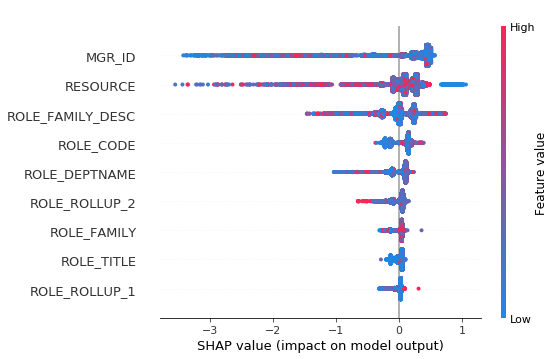

In [52]:
shap.summary_plot(shap_values, X)

In [53]:
X_small = X.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(shap_small, X_small)

# Оценка факторов

In [54]:
from catboost.eval.catboost_evaluation import *
learn_params = {'iterations': 20, # 2000
                'learning_rate': 0.5, # we set big learning_rate, because we have small #iterations
                'random_seed': 0,
                'logging_level': 'Silent',
                'loss_function' : 'Logloss',
                'boosting_type': 'Plain'}
evaluator = CatboostEvaluation('amazon/train.tsv',
                               fold_size=10000, # <= 50% of dataset
                               fold_count=20,
                               column_description='amazon/train.cd',
                               partition_random_seed=0,
                               #working_dir=... 
)
result = evaluator.eval_features(learn_config=learn_params,
                                 eval_metrics=['Logloss', 'Accuracy'],
                                 features_to_eval=[6, 7, 8])

In [55]:
from catboost.eval.evaluation_result import *
logloss_result = result.get_metric_results('Logloss')
logloss_result.get_baseline_comparison(ScoreConfig(ScoreType.Rel, overfit_iterations_info=False))

PValue     Score  Quantile 0.005  Quantile 0.995 Decision
Features: 6  0.999880  1.649811        1.130594        2.279362     GOOD
Features: 7  0.966660  0.445930       -0.037093        0.926472  UNKNOWN
Features: 8  0.947778  0.439304       -0.164215        0.955824  UNKNOWN

In [56]:
logloss_result.get_baseline_comparison(ScoreConfig(ScoreType.Abs, overfit_iterations_info=False))

PValue     Score  Quantile 0.005  Quantile 0.995 Decision
Features: 6  0.999880  0.289915        0.194508        0.393620     GOOD
Features: 7  0.966660  0.079503       -0.006191        0.177956  UNKNOWN
Features: 8  0.947778  0.077271       -0.018742        0.175746  UNKNOWN

# Сохранение модели

In [57]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin') # format = cbm, cpp, python, coreml
my_best_model.save_model('catboost_model.py', format='python')

In [58]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())

{'logging_level': u'Silent', 'iterations': 10, 'loss_function': u'Logloss'}


# Подбор параметров

# Скорость

In [59]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    logging_level='Silent',
    plot=True
)

TWV0cmljVmlzdWFsaXplcihkYXRhPXsnY2F0Ym9vc3RfaW5mbyc6IHsnY29udGVudCc6IHsnZGF0YSc6IHsnbWV0YSc6IHt1J25hbWUnOiB1J2V4cGVyaW1lbnQnLCB1J3Rlc3RfbWV0cmljcyfigKY=


# Качество

In [60]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    logging_level='Silent',
    eval_set=(X_validation, y_validation),
    plot=True
)

TWV0cmljVmlzdWFsaXplcihkYXRhPXsnY2F0Ym9vc3RfaW5mbyc6IHsnY29udGVudCc6IHsnZGF0YSc6IHsnbWV0YSc6IHt1J25hbWUnOiB1J2V4cGVyaW1lbnQnLCB1J3Rlc3RfbWV0cmljcyfigKY=


# Как обучить лучшую модель

In [61]:
best_model = CatBoostClassifier(
    random_seed=63,
    iterations=int(tunned_model.tree_count_ * 1.2),
)
best_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=100
)

0:	learn: 0.6570013	total: 54.9ms	remaining: 57.1s
100:	learn: 0.1618495	total: 4.56s	remaining: 42.5s
200:	learn: 0.1523377	total: 9.39s	remaining: 39.3s
300:	learn: 0.1488781	total: 14.1s	remaining: 34.6s
400:	learn: 0.1464285	total: 19.1s	remaining: 30.6s
500:	learn: 0.1440524	total: 24.2s	remaining: 26.1s
600:	learn: 0.1421510	total: 29.2s	remaining: 21.4s
700:	learn: 0.1404207	total: 34.2s	remaining: 16.6s
800:	learn: 0.1390639	total: 39.4s	remaining: 11.8s
900:	learn: 0.1378241	total: 44.8s	remaining: 6.96s
1000:	learn: 0.1365997	total: 50s	remaining: 2s


# Применим модель к отложенной выборке

In [62]:
X_test = test_df.drop('id', axis=1)
test_pool = Pool(data=X_test, cat_features=cat_features)
contest_predictions = best_model.predict_proba(test_pool)
print('Predictoins:')
print(contest_predictions)

Predictoins:
[[0.2958 0.7042]
 [0.0163 0.9837]
 [0.0109 0.9891]
 ...
 [0.0073 0.9927]
 [0.0566 0.9434]
 [0.0142 0.9858]]


# Подготовим датасет к сабмиту

In [63]:
f = open('submit.csv', 'w')
f.write('Id,Action\n')
for idx in range(len(contest_predictions)):
    line = str(test_df['id'][idx]) + ',' + str(contest_predictions[idx][1]) + '\n'
    f.write(line)
f.close()

# Еще один секрет

In [65]:
best_model_with_test = CatBoostClassifier(
    random_seed=63,
    iterations=int(tunned_model.tree_count_ * 1.2),
)
best_model_with_test.fit(
    X, y,
    cat_features=cat_features,
    verbose=100,
    eval_set=test_pool,
)

0:	learn: 0.6570013	test: 0.7359840	best: 0.7359840 (0)	total: 49.5ms	remaining: 51.5s
100:	learn: 0.1575459	test: 3.4617990	best: 0.7359840 (0)	total: 5.56s	remaining: 51.7s
200:	learn: 0.1485990	test: 3.8679209	best: 0.7359840 (0)	total: 12.3s	remaining: 51.5s
300:	learn: 0.1455603	test: 3.9498749	best: 0.7359840 (0)	total: 19.2s	remaining: 47.2s
400:	learn: 0.1429984	test: 3.9908992	best: 0.7359840 (0)	total: 26.7s	remaining: 42.6s
500:	learn: 0.1407196	test: 4.0147905	best: 0.7359840 (0)	total: 34.1s	remaining: 36.7s
600:	learn: 0.1389320	test: 4.0332493	best: 0.7359840 (0)	total: 41.6s	remaining: 30.5s
700:	learn: 0.1373828	test: 4.0570521	best: 0.7359840 (0)	total: 49s	remaining: 23.8s
800:	learn: 0.1359537	test: 4.0707042	best: 0.7359840 (0)	total: 56.5s	remaining: 16.9s
900:	learn: 0.1347847	test: 4.0882538	best: 0.7359840 (0)	total: 1m 3s	remaining: 9.89s
1000:	learn: 0.1334772	test: 4.0973048	best: 0.7359840 (0)	total: 1m 10s	remaining: 2.83s

bestTest = 0.735983991
bestItera

In [66]:
print(best_model_with_test.tree_count_)

1041


In [67]:
contest_predictions_with_test = best_model_with_test.predict_proba(test_pool)
f = open('submit_with_test.csv', 'w')
f.write('Id,Action\n')
for idx in range(len(contest_predictions)):
    line = str(test_df['id'][idx]) + ',' + str(contest_predictions_with_test[idx][1]) + '\n'
    f.write(line)
f.close()

Удачи!!!